<a href="https://colab.research.google.com/github/Ericsmrk/csci-167/blob/main/intel_image_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


After investigating suitable datasets to learn more about using a convolutional neural network (CNN) for image classification, I came across the Intel Image Classification Dataset. Found on Kaggle [here](https://www.kaggle.com/datasets/puneet6060/intel-image-classification), the dataset consists of around 25 thousand images of size 150 by 150 depicting "Natural Scenes" from around the world that are classified under six categories: buildings, forests, glaciers, mountains, sea, and streets. This dataset is considered a real-world dataset that is simple but diverse enough for the scope of this class. This makes it a good choice for an introduction to CNN model creation. CNNs are widely known for highly effective feature extraction involved with image classification.

##Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Dropout,MaxPooling2D,Dense,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report

#Dataset Exploration

## Upload IIC Dataset

One of the first steps is to turn on the GPU.
Here are the instructions.

To enable the GPU, you need to change the runtime type:

Go to the 'Runtime' menu in your Colab notebook.
Select 'Change runtime type'.
In the 'Hardware accelerator' dropdown menu, select 'GPU'.
Click 'Save'.

In [2]:
# Check if TensorFlow is using GPU
if tf.test.gpu_device_name():
  print("GPU is enabled and available")
else:
  print("GPU is not enabled or available")


GPU is enabled and available


First we need to upload the dataset into the colab environment, the best way to do this is to mount the google drive and then unzip the dataset zip file from there.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q /content/drive/MyDrive/167/project/Intel_IC_Dataset.zip -d ./data
print("Dataset extracted to './data'!")


Dataset extracted to './data'!


##Dataset Analysis

Now that we have been able to upload the dataset to our Colab Python environment. We can start to analyze the dataset. First, I will go over summarizations of the features, data types, and categories present in the dataset. Second, I will provide a description of the proprocessing steps required before jumping into model creation.

###Dataset Description

As you can see in the following cell, the dataset has a total of SIX categories of images: buildings, forest, glacier, mountain, sea, and street. We display the total number of images per category in both training and testing datasets followed by a bar graph for the datasets detailing the distributions.

In [5]:
# Define paths
train_dir = './data/seg_train/seg_train'
test_dir = './data/seg_test/seg_test'
pred_dir = './data/seg_pred/seg_pred'

# List categories
categories = os.listdir(train_dir)

print("Dataset Overview:")
print(f"- Number of categories: {len(categories)}")
print(f"- Categories: {categories}")

# Count the number of images in each category
print("\nImage Counts per Category (Training Set):")
for category in categories:
    category_path = os.path.join(train_dir, category)
    print(f"{category}: {len(os.listdir(category_path))} images")

print("\nImage Counts per Category (Testing Set):")
for category in categories:
    category_path = os.path.join(test_dir, category)
    print(f"{category}: {len(os.listdir(category_path))} images")


Dataset Overview:
- Number of categories: 6
- Categories: ['street', 'forest', 'glacier', 'buildings', 'sea', 'mountain']

Image Counts per Category (Training Set):
street: 2382 images
forest: 2271 images
glacier: 2404 images
buildings: 2191 images
sea: 2274 images
mountain: 2512 images

Image Counts per Category (Testing Set):
street: 501 images
forest: 474 images
glacier: 553 images
buildings: 437 images
sea: 510 images
mountain: 525 images


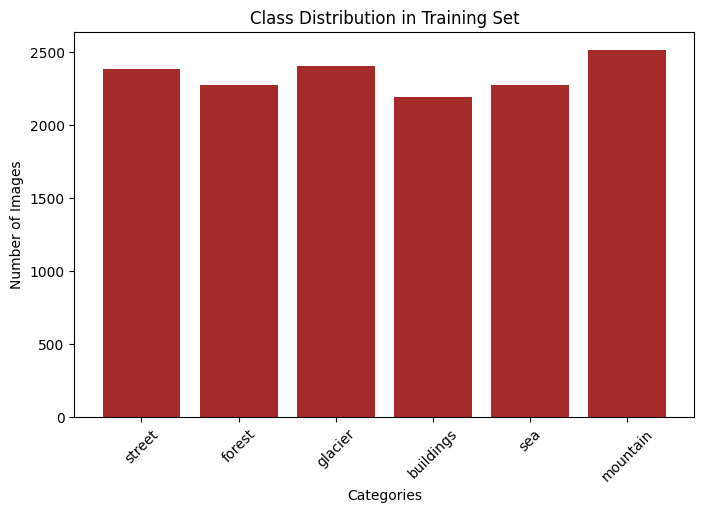

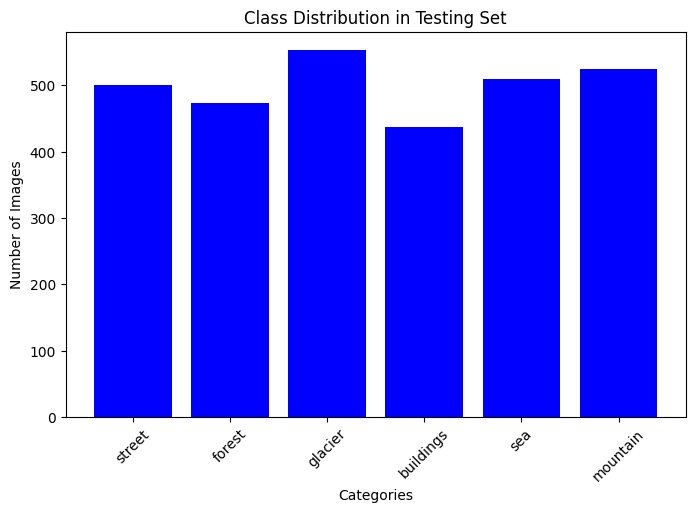

In [12]:
import matplotlib.pyplot as plt

# Count images in each category for training set
category_counts = {category: len(os.listdir(os.path.join(train_dir, category))) for category in categories}

# Plot distribution
plt.figure(figsize=(8, 5))
plt.bar(category_counts.keys(), category_counts.values(), color='brown')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.show()

# add a gap
print(" ")

# Count images in each category for testing set
category_counts = {category: len(os.listdir(os.path.join(test_dir, category))) for category in categories}

# Plot distribution
plt.figure(figsize=(8, 5))
plt.bar(category_counts.keys(), category_counts.values(), color='blue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Testing Set')
plt.xticks(rotation=45)
plt.show()

###Example Images
Next, lets look at some examples of the images that are included in this dataset. First I will show some examples of the TRAINING IMAGES, followed by examples of the TESTING IMAGES.

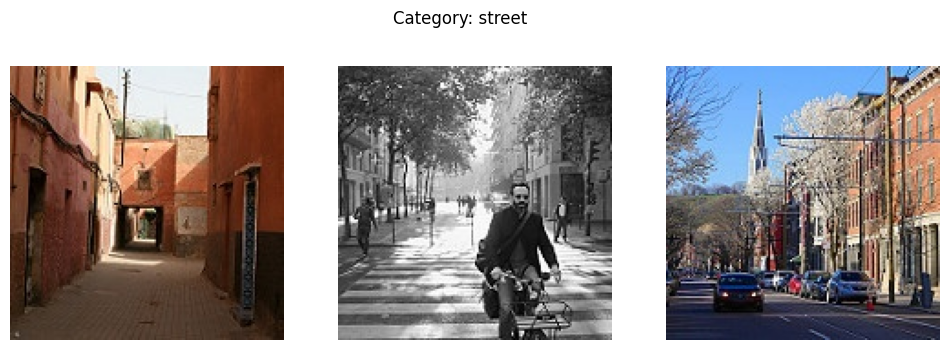

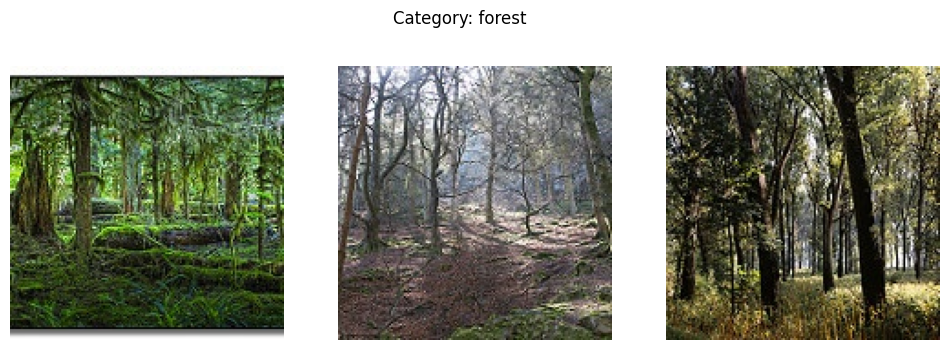

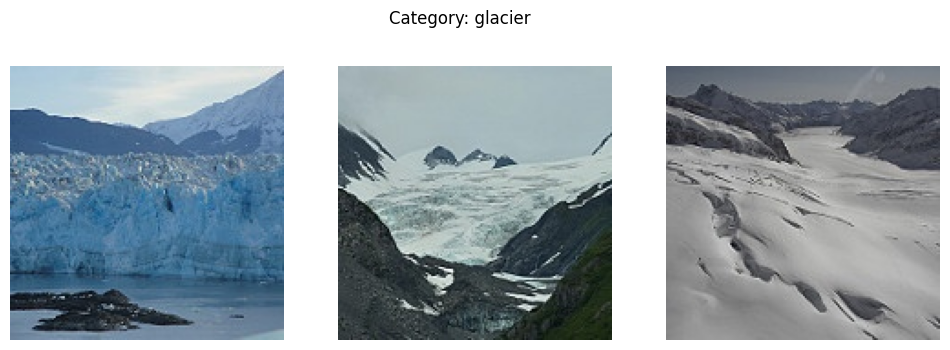

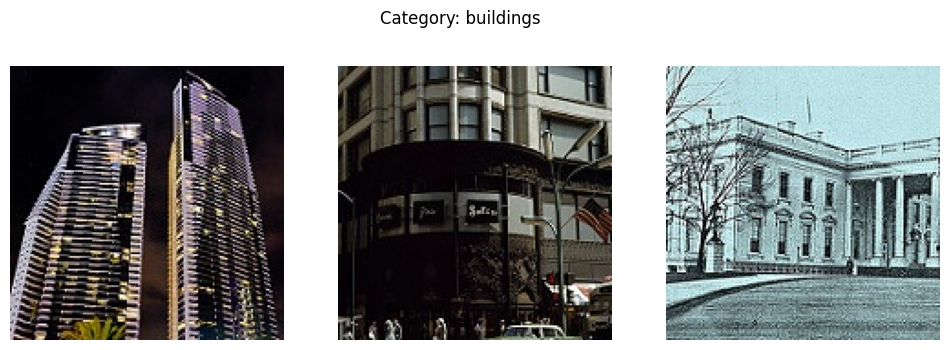

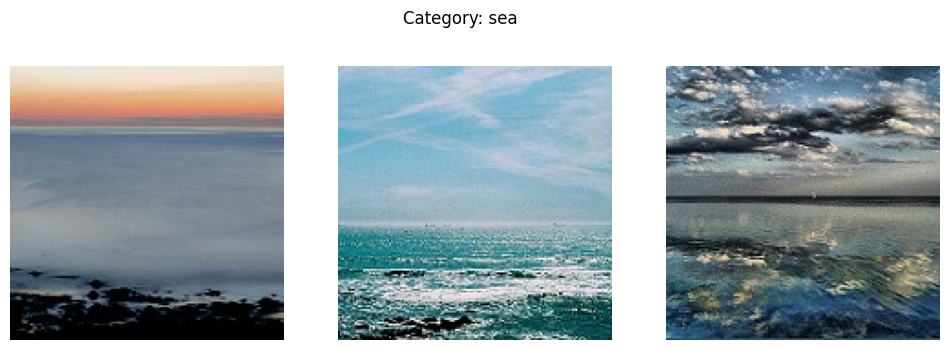

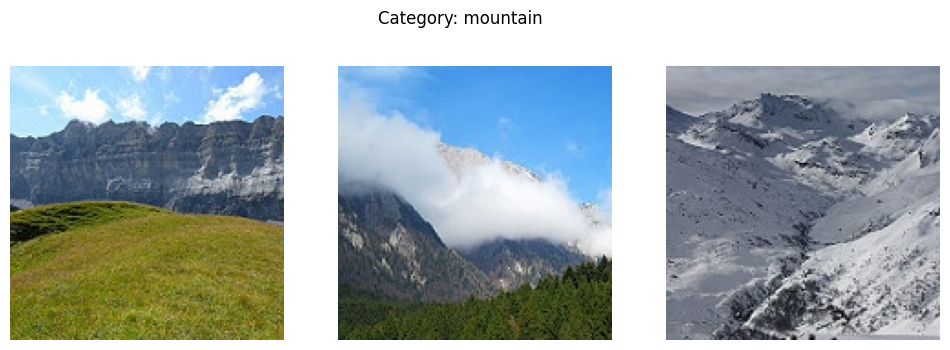

In [6]:
# Display a few random images from each category
for category in categories:
    category_path = os.path.join(train_dir, category)
    image_files = os.listdir(category_path)
    selected_images = random.sample(image_files, 3)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"Category: {category}")

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(category_path, image_file)
        image = mpimg.imread(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.show()

In [ ]:
#START PREPROCESSING


IMAGE_SIZE = (228, 228)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

classes_names=train_ds.class_names
print(classes_names)

def getImagePaths(path):
    image_names=[]
    for dirname, _,filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

images_paths = getImagePaths(pred_dir)
pred_path_lens = len(images_paths)
print(pred_path_lens)

images_paths = getImagePaths(train_dir)
train_path_lens = len(images_paths)
print(train_path_lens)

images_paths = getImagePaths(test_dir)
test_path_lens = len(images_paths)
print(test_path_lens)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
7301
14034
3000
